# Pressure, Tested with Jupiter-like Conditions
Scrapping the old pressure test and rewriting from scratch

### Notes
* It looks like the Y matrix values are opposite. I should probably multiply by -1.
* gradW should be returning values on the order of e-35
* Current values of dt and h are not finalized
* gradW for the interval between 1 and 2 returns higher magnitude values that gradW for the interval below 1

### Imports

In [1]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import animation
from matplotlib.collections import PatchCollection

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb

Populating the interactive namespace from numpy and matplotlib


### Constants

In [2]:
dt = 1e-2
stepN = 100
h = 2e9                           # smoothing length, 5.5e8 gives nice clumping


### Initialize position, velocity, mass, pressure, density, and time

In [3]:
### --- Distribution Case 1 --- ###
xyDistribution = np.array(([1.0e8, 1.0e8], 
                           [-1.0e8, -1.0e8])) 
nParticles = len(xyDistribution)

### --- Distribution Case 1.5 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -5.0e8],
#                            [0.0, 1.0e8]))
# nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
# nParticles = 250
# xyDistribution = np.random.normal(0,5e7, size=(nParticles, 2))

# Velocity and mass distribution
velocityDistribution = np.zeros_like(xyDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles,2,stepN))


timeArray = np.arange(0, stepN*dt, dt)

[]

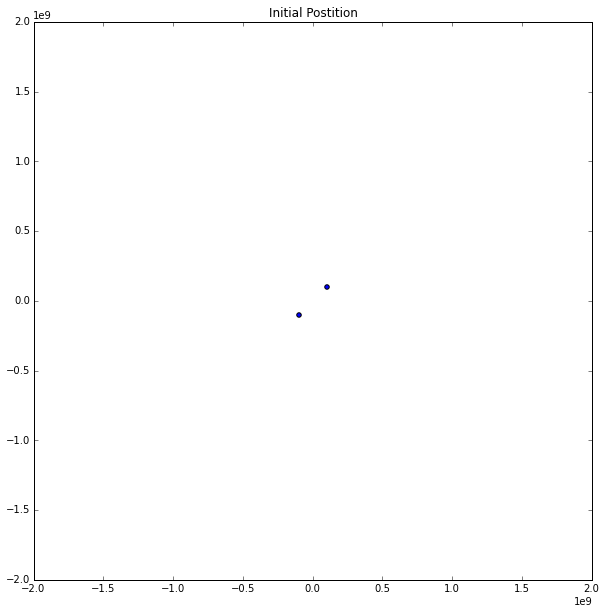

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.xlim(-2e9, 2e9)
plt.ylim(-2e9, 2e9)
plt.title("Initial Postition")
plt.plot()

### Define smoothing gradient

From http://arxiv.org/pdf/1012.1885.pdf, in 2-D:

\begin{equation}
W(r,h) = \frac{10}{7\pi h^2} \left( \frac{1}{4}(2-q)^3 - (1 - q)^3 \right)
\end{equation}

\begin{equation}
W(r,h) = \frac{10}{7\pi h^2} \left( \frac{1}{4}(2-q)^3) \right)
\end{equation}

\begin{equation}
\frac{dW}{dx} = -\frac{15x(3h - r)}{14 \pi h^4 r}
\end{equation}

\begin{equation}
\frac{dW}{dx} = -\frac{15x(r-2h)^2}{14 \pi h^3r}
\end{equation}
Then using Wolfram, the derivative with respect to Cartesian coordinates is:

In [5]:
def gradW(xyDist, h):
    '''
    Inputs:
        xyDist: a [2,1] array containing the difference in [x,y] position
            between two particles
        h: smoothing length
    Outputs:
        a [2,1] array containing the [x,y] component of gradW
    '''
    
    dist = np.sqrt(xyDist[0]**2 + xyDist[1]**2)
    
    if dist < h:
        return np.array(
                [3*xyDist[0]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyDist[1]*(3*dist - 4*h)/(4*np.pi*h**6)])
    # 2D kernel
#         return np.array(
#               [15*xyDist[0]*(3*dist - 4*h)/(14 * np.pi * h**5),
#                15*xyDist[1]*(3*dist - 4*h)/(14 * np.pi * h**5)])
    
    elif dist > 2 * h:
        return np.array([0,0])
    
    else:
        return np.array(
                [-3*xyDist[0]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyDist[1]*(-2*h+dist)**2/(4*h**6*np.pi*dist)])

In [6]:
def gradP():
    
    gradPArray = np.zeros_like(velocityDistribution)

    for i in range(0, nParticles):
        for j in range(i, nParticles):
            
            xdist = (xyDistribution[i,0]-xyDistribution[j,0])
            ydist = (xyDistribution[i,1]-xyDistribution[j,1])
            distArr = np.array([xdist,ydist])
            
            #gradPX = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[0]
            #gradPY = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[1]
            gradPX = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[0]
            gradPY = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[1]
            
            gradPArray[i,0] += gradPX
            gradPArray[i,1] += gradPY
            gradPArray[j,0] += gradPX
            gradPArray[j,1] += gradPY

            ### --- debugging --- ###
            print "distArr:", distArr
    return gradPArray

gradP()

distArr: [ 0.  0.]
distArr: [  2.00000000e+08   2.00000000e+08]
distArr: [ 0.  0.]


array([[-142.27401216, -142.27401216],
       [-142.27401216, -142.27401216]])

### RK1

In [7]:
t = 0
for i in range(stepN):
#    print gradP()
    t += 1
    ParticlePositionHistory[:,:,i] = xyDistribution
    deltaV = -gradP()/rhoDistribution[:,np.newaxis] * dt
    velocityDistribution += deltaV
    deltaPos = velocityDistribution * dt
    xyDistribution += deltaPos
    
### --- Debugging --- ###
    print "deltaV at timestep", t, "\n", deltaV
#    print "deltaPos at timestep", t, "\n", deltaPos
#    print "velocityDistribution at timestep", t, "\n", velocityDistribution

#     print "deltaPos:\n", deltaPos
#     print "xyDistribution:\n", xyDistribution

#     ParticleVelocityHistory[:,:,i] = -gradP()/rhoDistribution[:,np.newaxis] * dt


distArr: [ 0.  0.]
distArr: [  2.00000000e+08   2.00000000e+08]
distArr: [ 0.  0.]
deltaV at timestep 1 
[[ 0.47424671  0.47424671]
 [ 0.47424671  0.47424671]]
distArr: [ 0.  0.]
distArr: [  2.00000000e+08   2.00000000e+08]
distArr: [ 0.  0.]
deltaV at timestep 2 
[[ 0.47424671  0.47424671]
 [ 0.47424671  0.47424671]]
distArr: [ 0.  0.]
distArr: [  2.00000000e+08   2.00000000e+08]
distArr: [ 0.  0.]
deltaV at timestep 3 
[[ 0.47424671  0.47424671]
 [ 0.47424671  0.47424671]]
distArr: [ 0.  0.]
distArr: [  2.00000000e+08   2.00000000e+08]
distArr: [ 0.  0.]
deltaV at timestep 4 
[[ 0.47424671  0.47424671]
 [ 0.47424671  0.47424671]]
distArr: [ 0.  0.]
distArr: [  2.00000000e+08   2.00000000e+08]
distArr: [ 0.  0.]
deltaV at timestep 5 
[[ 0.47424671  0.47424671]
 [ 0.47424671  0.47424671]]
distArr: [ 0.  0.]
distArr: [  2.00000000e+08   2.00000000e+08]
distArr: [ 0.  0.]
deltaV at timestep 6 
[[ 0.47424671  0.47424671]
 [ 0.47424671  0.47424671]]
distArr: [ 0.  0.]
distArr: [  2.0000000

In [8]:
print ParticlePositionHistory[:,:,3]

[[  1.00000000e+08   1.00000000e+08]
 [ -1.00000000e+08  -1.00000000e+08]]


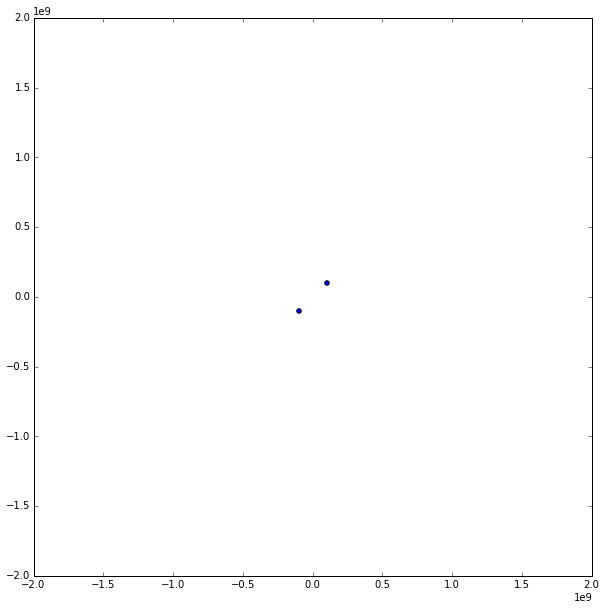

In [9]:
slider = FloatSlider(description='Time', min=0, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[:,0,time]
    y = ParticlePositionHistory[:,1,time]
    fig = plt.figure(figsize=(10,10))
    plt.scatter(x, y)
    plt.xlim(-2e9, 2e9)
    plt.ylim(-2e9, 2e9)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

The figure agrees with Figure 2 of Price's paper.


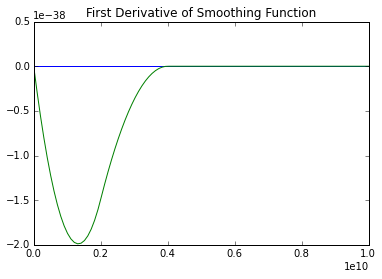

In [11]:
r_range = np.linspace(0,1e10,100)
W_range = []
for i in r_range:
    W_range.append(gradW([0,i], h))
plt.plot(r_range, W_range)
plt.title('First Derivative of Smoothing Function')
print "The figure agrees with Figure 2 of Price's paper."